Based on https://github.com/qubvel/segmentation_models

### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [62]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
from keras import utils as np_utils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [63]:
DATA_DIR = './data/'

In [64]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [65]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
   
    CLASSES = ['frontwheel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        
        self.masks_fps = []
        for filename in self.ids: 
            filenamerest,file_extension = os.path.splitext(filename)
            mask = filenamerest + '.png'
            self.masks_fps.append(os.path.join(masks_dir, mask )) 
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

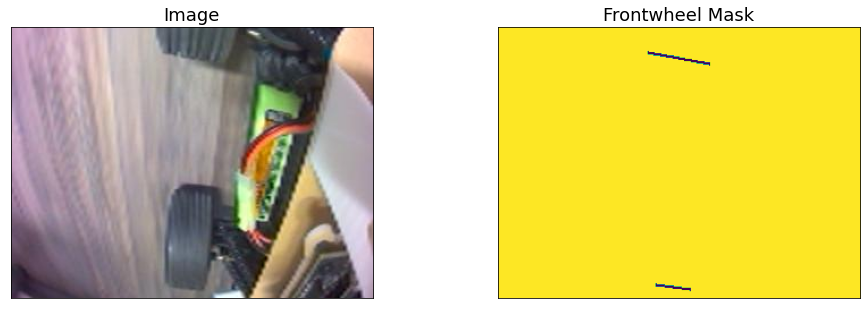

In [66]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['frontwheel'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    frontwheel_mask=mask[...,0].squeeze(),
)

### Augmentations

In [67]:
import albumentations as A

In [68]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        #A.HorizontalFlip(p=0.5),

        #A.ShiftScaleRotate(scale_limit=0, rotate_limit=10, shift_limit=0.00, p=1, border_mode=1),

        A.PadIfNeeded(min_height=256, min_width=320, always_apply=True, border_mode=1),
        #A.RandomCrop(height=224, width=320, always_apply=True),

        #A.IAAAdditiveGaussianNoise(p=0.2),
        A.GaussNoise(p=0.2),         
        #A.IAAPerspective(p=0.5),
        #A.Perspective(p=0.5),
        

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                #A.IAASharpen(p=1),
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(256, 320, always_apply=True, border_mode=1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

./data/train/3340_cam-image_array_.jpg


/home/apandy/environemnts/car/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/apandy/environemnts/car/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


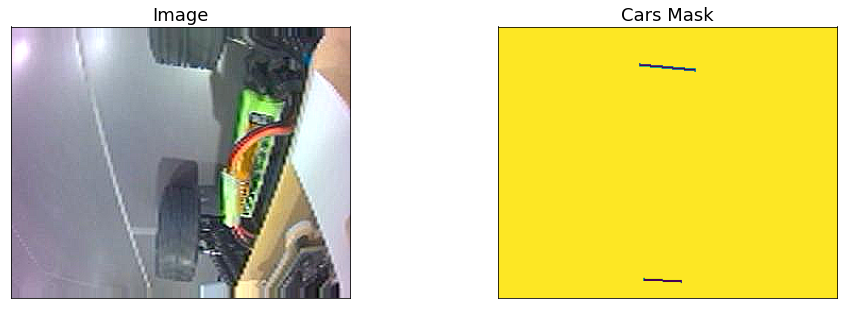

./data/train/3098_cam-image_array_.jpg


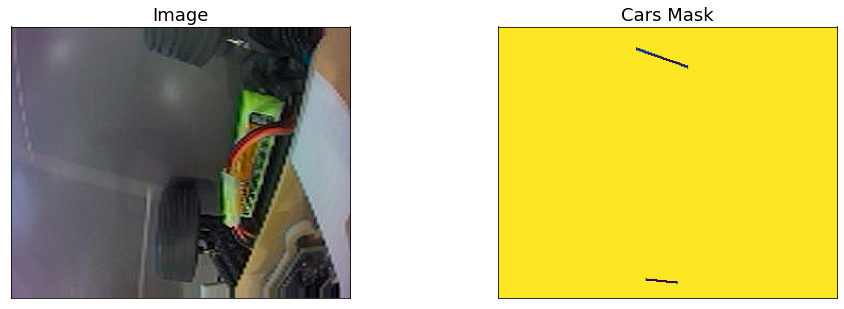

./data/train/2993_cam-image_array_.jpg


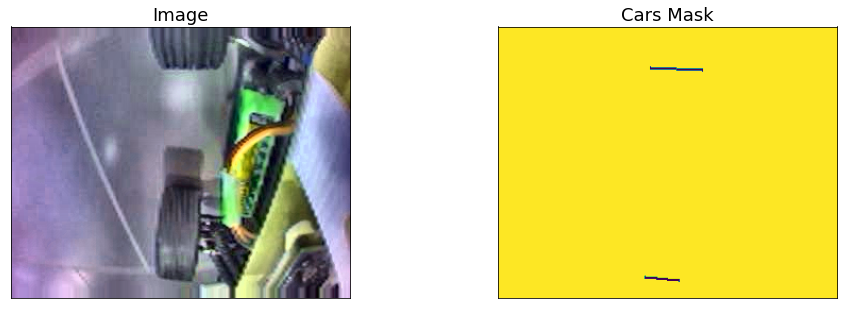

./data/train/2994_cam-image_array_.jpg


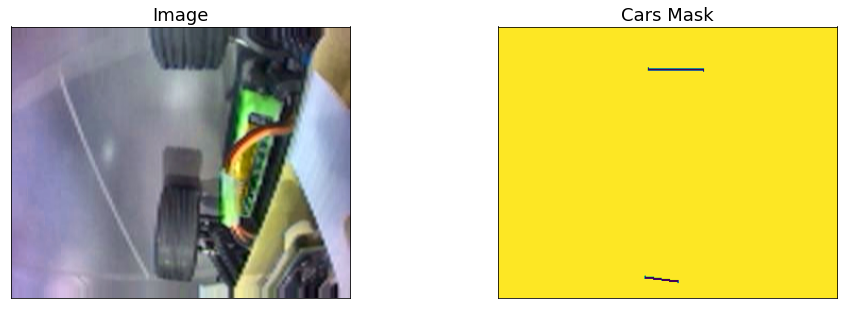

./data/train/3131_cam-image_array_.jpg


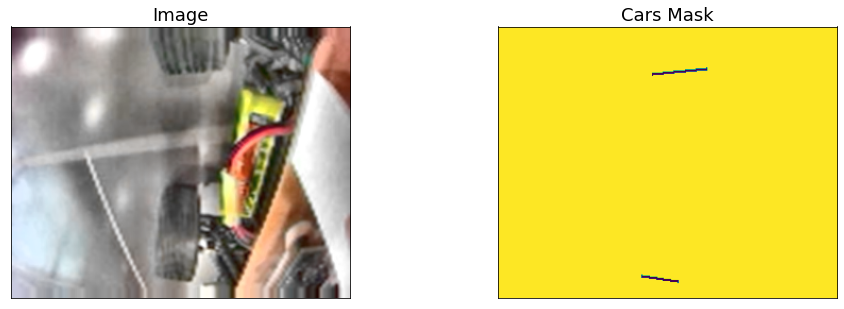

In [69]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['frontwheel'], augmentation=get_training_augmentation())

n = 5
ids = np.random.choice(np.arange(len(dataset)), size=n)

for i in ids:
    print(dataset.images_fps[i])
    image, mask = dataset[i] # get some sample
    visualize(
        image=image, 
        cars_mask=mask[..., 0].squeeze(),
    )



# Segmentation model training

In [70]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

'tf.keras'

In [71]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['frontwheel']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [72]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [73]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [74]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [75]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [76]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
56/56 [==============================] - 16s 161ms/step - loss: 0.4331 - iou_score: 0.4169 - f1-score: 0.5647 - val_loss: 0.7549 - val_iou_score: 0.1685 - val_f1-score: 0.2874 - lr: 1.0000e-04
Epoch 2/40
56/56 [==============================] - 8s 144ms/step - loss: 0.2813 - iou_score: 0.9092 - f1-score: 0.9515 - val_loss: 0.4148 - val_iou_score: 0.3852 - val_f1-score: 0.5536 - lr: 1.0000e-04
Epoch 3/40
56/56 [==============================] - 8s 146ms/step - loss: 0.2222 - iou_score: 0.9808 - f1-score: 0.9903 - val_loss: 0.2840 - val_iou_score: 0.9163 - val_f1-score: 0.9556 - lr: 1.0000e-04
Epoch 4/40
56/56 [==============================] - 8s 144ms/step - loss: 0.1903 - iou_score: 0.9896 - f1-score: 0.9948 - val_loss: 0.2177 - val_iou_score: 0.9930 - val_f1-score: 0.9965 - lr: 1.0000e-04
Epoch 5/40
56/56 [==============================] - 8s 144ms/step - loss: 0.1691 - iou_score: 0.9928 - f1-score: 0.9964 - val_loss: 0.1782 - val_iou_score: 0.9949 - val_f1-score: 0.9975 -

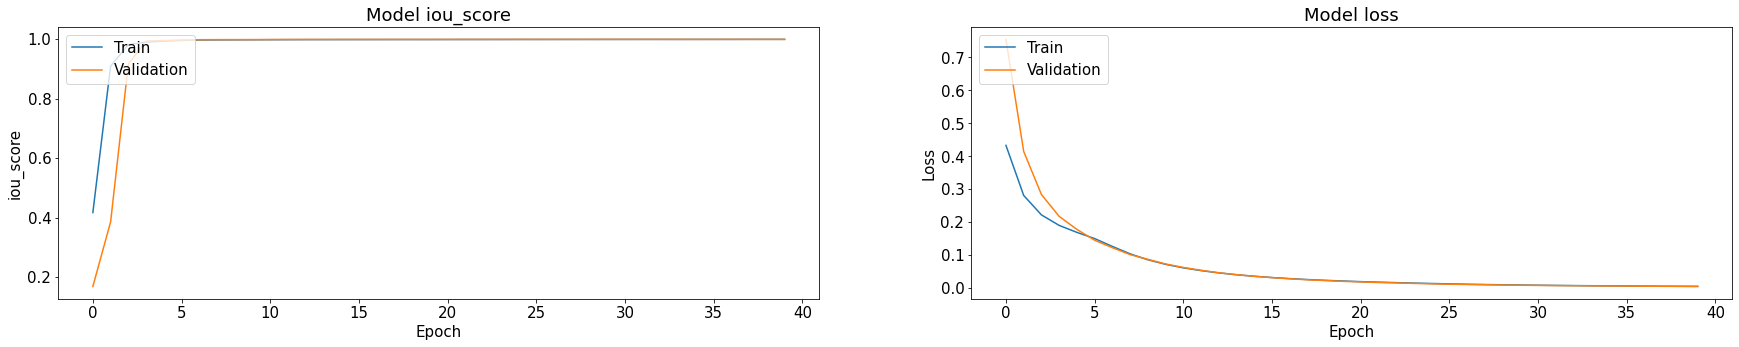

In [77]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model Evaluation

In [78]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [79]:
# load best weights
model.load_weights('best_model.h5') 

In [80]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

5/5 [==============================] - 0s 12ms/step - loss: 0.0051 - iou_score: 0.9988 - f1-score: 0.9994
Loss: 0.0050654
mean iou_score: 0.99878
mean f1-score: 0.99939


# Correlation calculation of predicted angle and PWM values

In [82]:
model.load_weights('best_model.h5')

def mask_to_points(mask):
    points = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] == 0:
                points.append([mask.shape[1]-j,i])
    return points

def mask_to_degree(mask):
    points_front = mask_to_points(mask[0:50,:])
    
    pca = PCA(n_components=1) 
    pca.fit(points_front)    
    v1 = pca.components_[0]        
    
    inv = np.arctan2(v1[1], v1[0])    
    degree = np.degrees(inv)
    if degree < 0:
        degree = (180+degree) 
    if degree > 90:
        degree = (degree-180) 
    
    return 0-degree

def apply_ackermann_steering(degree, isLeftWheel = True):
    
    #Ackermann steering theta
    L = 178 #wheelbase
    b = 165 #
    
    if isLeftWheel:    
        mirror = 1 # positive degree means outside of a turn
    elif not isLeftWheel:
        mirror = -1 # positive degree means inside of a turn
        
    if degree > 0:  #left wheel,
        tg_alpha = math.tan(math.radians(degree))
        tg_theta = L* tg_alpha / (L - mirror * tg_alpha*(b/2))
    elif degree <= 0:  #left wheel, inside of a turn
        tg_alpha = math.tan(math.radians(abs(degree)))
        tg_theta = -1* L* tg_alpha / (L + mirror * tg_alpha*(b/2))    
        
    theta = math.degrees(math.atan(tg_theta))
        
    return theta

def calculate_wheels_angle_only_front_pca(image, isLeftWheel):
    
    image = get_validation_augmentation()(image=image)['image']
    image = get_preprocessing(sm.get_preprocessing(BACKBONE))(image=image)['image']

    image2 = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image2).round()
    mask = pr_mask[..., 0].squeeze()    

    degree = mask_to_degree(mask)
    theta = apply_ackermann_steering(degree, isLeftWheel)
    
    return theta 

In [83]:
DATA_DIR = './data/merged'

In [84]:
import json
from sklearn.decomposition import PCA
import math
import pandas as pd

ids = os.listdir(DATA_DIR)
prediction_result = []
json_fps = [os.path.join(DATA_DIR, image_id) for image_id in ids if image_id.startswith('record')]
json_fps.sort()
for file in json_fps:
    with open(file, 'r') as f:
        jsonObj = json.load(f)
        imgFile = jsonObj['cam/image_array']
        pvm = jsonObj['user/angle']
        image = cv2.imread(os.path.join(DATA_DIR, imgFile))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        camera_angle = calculate_wheels_angle_only_front_pca(image, isLeftWheel=False)        
        prediction_result.append((imgFile, pvm, camera_angle ))   

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


In [85]:
def show_statistics(pwms, predictions, frames):

    print('Sample count: ', len(predictions))
    print('Cov', np.corrcoef([pwms,predictions]))    
    
    predictions2 = predictions[:frames]
    mean = (max(predictions2) - min(predictions2))/2
    predictions3 = (predictions2 -  (min(predictions2) + mean) ) / mean
    sse = np.sum(((predictions3 - pwms)**2))
    
    print('Sample count: ', len(predictions3))
    print('SSE', sse)

In [86]:
df = pd.DataFrame(prediction_result)

shift=4

pwms = df[1][:-shift]
predictions = df[2].shift(-shift)[:-shift]
show_statistics(pwms,predictions, 490)

Sample count:  496
Cov [[1.         0.98496073]
 [0.98496073 1.        ]]
Sample count:  490
SSE 6.206316490505786


Sample count:  496
Cov [[1.         0.98496073]
 [0.98496073 1.        ]]
Sample count:  490
SSE 6.206316490505786


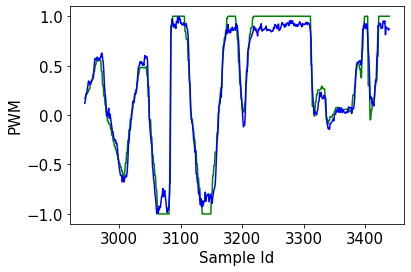

In [87]:
def show_pwm_prediction(pwms, preditions,text, start_id=2944):
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.plot(idxs, pwms, color="green")
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('PWM')
    ax.plot(idxs, preditions, color="blue")

shift=4

df = pd.DataFrame(prediction_result)

predicted_angle = df[2].shift(-shift)[:-shift]

# Theese values can be obtained by measurement as well.
pmin = min(predicted_angle)
pmax = max(predicted_angle)

pnorm =( predicted_angle - pmin )/ (pmax-pmin) 
ppwm = pnorm * 2 -1

shift=4

pwms = df[1][:-shift]
predictions = ppwm

plt.rcParams.update({'font.size': 15})

show_pwm_prediction(pwms,predictions, 'Correlation between original signal and angle prediction.')
show_statistics(pwms,predictions, 490)